# Taller 4

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import sympy as sym 
import random as rand
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import qexpy as q
from scipy import integrate
from scipy.integrate import odeint

## 1. Integrador de Beeman  1976

Analizando las ecuaciones 9a, 9b y 9c, identificamos que  los índices de la sumatoria no tienen sentido, puesto que la sumatoria varía de acuerdo al subíndice p. Sin embargo, este solo acompaña a los coeficientes b, c y d; y se podría sacar la aceleración de esta sumatoria ya que esta solo depende del n y de q, que son valores constantes en cada iteración. Por lo que si el subíndice p solo actúa sobre coeficientes, la sumatoria completa sería un termino constante.

De acuerdo a lo que indica el autor, el integrador de Beeman parte de las ecuaciones del algoritmo de Verlet dadas por:

$$
r_{n+1}=2r_n -r_{n-1}+h^2a_n
$$

y la evaluación en punto medio de v_n

$$
v_n=(r_{n+1}-r_{n-1})/(2h)
$$

De modo que si se parte de la expansiom en serie de Taylor de tercer orden para $x(t+h)$, dada por: 

$$
x(t+\Delta t)=x(t)+x'(t)\Delta t +x''(t)\frac{\Delta t^2}{2}+x^{(3)}\frac{\Delta t^3}{6}+\mathcal{O}(h^4)
$$

que se puede reescribir como:
$$
x(t+\Delta t)=x(t)+v(t)\Delta t +a(t)\frac{\Delta t^2}{2}+a'(t)\frac{\Delta t^3}{6}+\mathcal{O}(h^4)
$$

donde la derivada de la aceleración, según Verlet, estaría dada por:

$$
a'(t)=\frac{a(t+\Delta t)- a(t-\Delta t)}{2\Delta t}
$$


Insertando este término en la expansión previamente mencionada, se tendría lo siguiente,

$$
x(t+\Delta t)=x(t)+v(t)\Delta t +a(t)\frac{\Delta t^2}{2}+\frac{a(t+\Delta t)- a(t-\Delta t)}{12}\Delta t^2+\mathcal{O}(h^4)
$$

Por ende, para llegar a la ecuación del predictor se tiene,

$$
\begin{align*}
x(t+\Delta t)&=x(t)+v(t)\Delta t +a(t)\frac{\Delta t^2}{2}+\frac{2a(t)-a(t+\Delta t)- a(t-\Delta t)}{12}\Delta t^2+\mathcal{O}(h^4)\\
&= x(t)+v(t\Delta t)+\frac{\Delta t^2}{6}(4a(t)-a(t-\Delta t))
\end{align*}
$$

escribiendo esto en forma de serie se tendría y con $\Delta t=h$

$$
\begin{align}
r_{n+1}&=r_n +hv_n+\frac{h^2}{6}(4a_n -a_{n-1})
\end{align}
$$


Por otro lado, patra el corrector de posición se tendría,
$$
\begin{align*}
x(t+\Delta t)&=x(t)+v(t)\Delta t +a(t)\frac{\Delta t^2}{2}+\frac{-2a(t)+a(t+\Delta t)+ a(t-\Delta t)}{12}\Delta t^2+\mathcal{O}(h^4)\\
&= x(t)+v(t)\Delta t+\frac{\Delta t^2}{6}(4a(t)-a(t)-\Delta t)
\end{align*}
$$

reescribiendo en forma de serie se tendría
$$
\begin{align}
r_{n+1}&=r_n +hv_n+\frac{h^2}{6}(a_{n+1}+2a_{n})
\end{align}
$$

Finalmente, para obtener el corrector de la velocidad, se tendría 

$$
\begin{align}
hv_n&=x_n-x_{n-1}+h^2a_n-h^2,\frac{2a_n}{3}+h^2\frac{a_{n-1}}{6}\\
&=x_{n-1}-r_n+\frac{h^2}{6}(2a_{n+1}+a_n)
\end{align}
$$


## 2. Integrador de Adams-Basforth
#### Demostración para 3 puntos

In [2]:
h=sym.Symbol("h",real=True)
f_n=sym.Symbol("f_n",real=True)
fn_1=sym.Symbol("f_n-1",real=True)
fn1=sym.Symbol("f_n+1",real=True)
fn_2=sym.Symbol("f_n-2",real=True)
t=sym.Symbol("t",real=True)

In [3]:
def Lagrange(x,xi,j):
    
    prod = 1.0
    n = len(xi)
    
    for i in range(n):
        if i != j:
            prod *= (x - xi[i])/(xi[j]-xi[i])
            
    return prod

In [4]:
def Interpolate(x,xi,yi):
    
    Sum = 0.
    n = len(xi)
    
    for j in range(n):
        Sum += yi[j]*Lagrange(x,xi,j)
        
    return Sum

In [5]:
fs_2=np.array([fn_2,fn_1,f_n])
ts_2=np.array([-2*h,-h,0])
pol2=Interpolate(t,ts_2,fs_2)
pol2

0.5*f_n*(h + t)*(2*h + t)/h**2 - 1.0*f_n-1*t*(2*h + t)/h**2 + 0.5*f_n-2*t*(h + t)/h**2

In [6]:
integ2=sym.integrate(pol2,(t,0,h))
sym.simplify(integ2)

h*(1.91666666666667*f_n - 1.33333333333333*f_n-1 + 0.416666666666667*f_n-2)

#### Demostración para 4 puntos

In [7]:
fn_3=sym.Symbol("f_n-3",real=True)
fs_22=np.array([fn_3,fn_2,fn_1,f_n])
ts_22=np.array([-3*h,-2*h,-h,0])
pol22=Interpolate(t,ts_22,fs_22)
pol22

0.166666666666667*f_n*(h + t)*(2*h + t)*(3*h + t)/h**3 - 0.5*f_n-1*t*(2*h + t)*(3*h + t)/h**3 + 0.5*f_n-2*t*(h + t)*(3*h + t)/h**3 - 0.166666666666667*f_n-3*t*(h + t)*(2*h + t)/h**3

In [8]:
integ22=sym.integrate(pol22,(t,0,h))
sym.simplify(integ22)

h*(2.29166666666667*f_n - 2.45833333333333*f_n-1 + 1.54166666666667*f_n-2 - 0.375*f_n-3)

## 3. Integrador de Adams-Moulton

#### Demostración para 3 puntos:

In [10]:
h=sym.Symbol("h",real=True)
f_n=sym.Symbol("f_n",real=True)
fn_1=sym.Symbol("f_n-1",real=True)
fn1=sym.Symbol("f_n+1",real=True)
fn_2=sym.Symbol("f_n-2",real=True)
t=sym.Symbol("t",real=True)


In [11]:
def Lagrange(x,xi,j):
    
    prod = 1
    n = len(xi)
    
    for i in range(n):
        if i != j:
            prod *= (x - xi[i])/(xi[j]-xi[i])
            
    return prod

In [12]:
def Interpolate(x,xi,yi):
    
    Sum = 0.
    n = len(xi)
    
    for j in range(n):
        Sum += yi[j]*Lagrange(x,xi,j)
        
    return Sum

In [13]:
fs3=np.array([fn_1,f_n,fn1])
ts3=np.array([-h,0,h])
pol=Interpolate(t,ts3,fs3)
pol

-f_n*(-h + t)*(h + t)/h**2 + f_n+1*t*(h + t)/(2*h**2) + f_n-1*t*(-h + t)/(2*h**2)

In [14]:
integ3=sym.integrate(pol,(t,0,h))
sym.simplify(integ3)

h*(8*f_n + 5*f_n+1 - f_n-1)/12

#### Demostración para 4 puntos

In [15]:
fs4=np.array([fn_2,fn_1,f_n,fn1])
ts4=np.array([-2*h,-h,0,h])
pol4=Interpolate(t,ts4,fs4)
pol4

-f_n*(-h + t)*(h + t)*(2*h + t)/(2*h**3) + f_n+1*t*(h + t)*(2*h + t)/(6*h**3) + f_n-1*t*(-h + t)*(2*h + t)/(2*h**3) - f_n-2*t*(-h + t)*(h + t)/(6*h**3)

In [16]:
integ4=sym.integrate(pol4,(t,0,h))
sym.simplify(integ4)

h*(19*f_n + 9*f_n+1 - 5*f_n-1 + f_n-2)/24

## 4. Integrador Simpléctico I 

El metodo de verlet dice que: 

$$
\begin{align*}
\vec{r_{n+1}}= \vec{r_n}+\vec{v_{n}h}+\frac{\vec{a_n}h^2}{2} \\
\vec{v_{n+1}}= \vec{v_n}+\frac{h}{2}(\vec{a_{n+1}}+\vec{a_n})
\end {align*}
$$


Ahora, a partir de estas ecuaciones hay que encontrar las derivadas parciales para poder formar el jacobiano. 


$$
\frac{\partial \vec{r_{n+1}}}{\vec{r_{n}}}= 1\\
$$
$$
\frac{\partial \vec{v_{n+1}}}{\vec{r_{n}}}= 0\\
$$
$$
\frac{\partial \vec{r_{n+1}}}{\vec{v_{n}}}= h\\
$$
$$
\frac{\partial \vec{v_{n+1}}}{\vec{v_{n}}}= 1\\
$$


Conociendo estas derivadas, es posible escribir del jacobiano de la siguiente forma:

$$
\begin{equation}
\begin{vmatrix}
 1& h\\
  0 & 1
\end{vmatrix}
=1*1 -h*0 =1
\end{equation}
$$

Por ende, al ser el jacobiano igual a 1 se puede concluir que el método es simpléctico.

## 6. Numerical Quantum Mechanics
### a)

Partiendo de la definición de serie potencia se tiene que toda función contínua se puede escribir de la siguiente manera,

$$
y(t+\Delta t)=y(t)+y'(t)\Delta t +y''(t)\frac{\Delta t^2}{2}+y^{(3)}\frac{\Delta t^3}{6}+...
$$

y por otro lado, para $-\Delta t$ se tendría,

$$
y(t-\Delta t)=y(t)-y'(t)\Delta t +y''(t)\frac{\Delta t^2}{2}-y^{(3)}\frac{\Delta t^3}{6}+...
$$


Si se suman ambas expresiones se llegaría a que,

$$
y(t+\Delta t)+y(t-\Delta t)=y(t)+y'(t)\Delta t +y(t)-y'(t)\Delta t +y''(t)\frac{\Delta t^2}{2}+y''(t)\frac{\Delta t^2}{2}+y^{(3)}\frac{\Delta t^3}{6}-y^{(3)}\frac{\Delta t^3}{6}+...\\
y(t+\Delta t)+y(t-\Delta t)=2y(t)+y''(t)\Delta t^2+y^{(4)}\frac{\Delta t^4}{12}+\mathcal{O} (\Delta t^6)
$$

Entonces, se llega a que,

$$
y_{n+1} +y_{n-1}=2y_n+y''_nh^2+y^{(4)}_n\frac{h^4}{12}+\mathcal{O}(\Delta t^6)
$$



Por otra parte, para implementar este métodos a una ecuación diferencial de la forma,

$$
\frac{d^2y}{dx^2}-R(x)y=S(x)
$$

Entonces, sabemos que, en su forma de sucesión tendría la forma,

$$
y''_n=R_ny_n+S_n
$$

de manera que su cuarta derivada estaría dada por,

$$
\begin{align*}
y^{(4)}_n&=\frac{R_{n+1}y_{n+1}+S_{n+1} -2(R_ny_n +S_n)+R_{n-1}y_{n-1} +S_{n-1}}{h^2}
\end{align*}
$$

Metiendo la segunda y cuarta derivada en la expresión a la que se llegó previamente, se tendría,

$$
y_{n+1} +y_{n-1}=2y_n+y''_nh^2+y^{(4)}_n\frac{h^4}{12}+\mathcal{O}(\Delta t^6)
$$
$$
y_{n+1} +y_{n-1}=2y_n+(R_ny_n+S_n)h^2+(\frac{R_{n+1}y_{n+1}+S_{n+1} -2(R_ny_n +S_n)+R_{n-1}y_{n-1} +S_{n-1}}{h^2})\frac{h^4}{12}+\mathcal{O}(\Delta t^6)
$$
$$
y_{n+1} +y_{n-1}=2y_n+R_ny_nh^2 +S_nh^2+R_{n+1}y_{n+1}\frac{h^2}{12}+S_{n+1}\frac{h^2}{12}-2R_ny_n\frac{h^2}{12}-2S_n\frac{h^2}{12}+R_{n-1}y_{n-1}\frac{h^2}{12}+S_{n-1}\frac{h^2}{12}+\mathcal{O}(\Delta t^6)
$$
$$
y_{n+1} +y_{n-1}=2y_n+R_ny_nh^2 +R_{n+1}y_{n+1}\frac{h^2}{12}-2R_ny_n\frac{h^2}{12}+R_{n-1}y_{n-1}\frac{h^2}{12}+(12S_n+S_{n+1}-2S_n+S_{n-1})\frac{h^2}{12}+\mathcal{O}(\Delta t^6)
$$
$$
\Big(-2-R_nh^2 -2R_n\frac{h^2}{12}\Big)y_n +\Big(-R_{n+1}\frac{h^2}{12}+1 \Big)y_{n+1}+\Big(-R_{n-1}\frac{h^2}{12}+1 \Big)y_{n-1}=(10S_n+S_{n+1}+S_{n-1})\frac{h^2}{12}+\mathcal{O}(\Delta t^6)
$$
$$
\Big(-R_{n+1}\frac{h^2}{12}+1 \Big)y_{n+1}-2\Big(1+R_n\frac{5h^2}{12}\Big)y_n+\Big(1-R_{n}\frac{h^2}{12}+1 \Big)y_{n-1}=(10S_n+S_{n+1}+S_{n-1})\frac{h^2}{12}+\mathcal{O}(\Delta t^6)
$$





### b)

In [29]:
h_=1
m=1
w=1

In [30]:
x_n=sym.Symbol("x_n",real=True)
E=sym.Symbol("E",real=True)

def V(x):
    return (1/2)*m*w**2*x**2
    

In [31]:
R_n=lambda x,E: 2*m*V(x)/h_**2- 2*m*E/h_**2

R_n(x_n,E)

-2*E + 1.0*x_n**2

### c)

In [32]:
N=1000
xs=np.linspace(-5,5,N)

### d)

Definida en el inciso b).

In [33]:
print("V(x)="+str(V(x_n)))

V(x)=0.5*x_n**2


### e)

In [70]:
def Numerov(x,V,E):
    h=x[1]-x[0]
    Rn=2*m*V(x)/h_**2- 2*m*E/h_**2
    
    psi=np.zeros(len(x))
    psi[0]=0
    psi[1]=1e-5
    
    for i in range (2,len(psi)):
        
        psi[i]=(-(1-h**2*Rn[i-2]/12)*psi[i-2] \
                +2*(1+5*h**2*Rn[i-1]/12)*psi[i-1])/((1-h**2*Rn[i]/12))
        
    return psi
        

### f)

In [71]:
dE=0.001

### g)

In [72]:
Es=[]
E=0
while len(Es)<6:
    psi1=Numerov(xs,V,E)[-1]
    psi2=Numerov(xs,V,E+dE)[-1]
    if psi1*psi2<0:
        Es.append(round(E,3))
    E=E+dE

Es

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

### h)


Text(0, 0.5, '$\\psi(x)$')

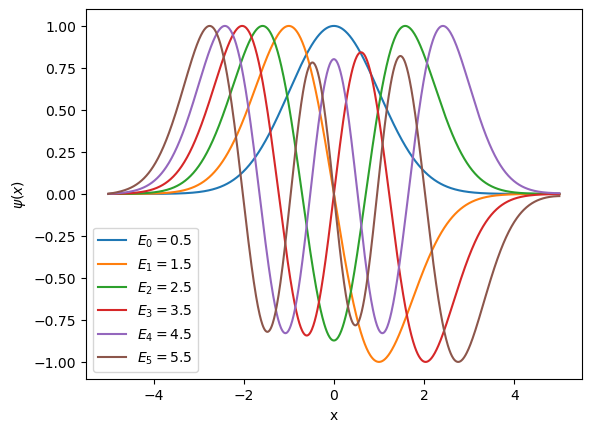

In [73]:
psis=np.zeros(len(Es))

for i in range(len(psis)):
    psi_=Numerov(xs,V,Es[i])/np.max(Numerov(xs,V,Es[i]))
    plt.plot(xs,psi_, label="$E_{%s}=%s$"%(i,Es[i]))
    plt.legend()

plt.xlabel("x")
plt.ylabel("$\psi(x)$")

                                    
                                    

### i)

In [87]:
def V2(x):
    return -10*np.exp(-x**2/20)

In [88]:
Es2=[]
E=-10
while len(Es2)<5:
    psi1=Numerov(xs,V2,E)[-1]
    psi2=Numerov(xs,V2,E+dE)[-1]
    if psi1*psi2<0:
        Es2.append(round(E,3))
    E=E+dE

Es2

[-9.51, -8.548, -7.625, -6.742, -5.899]

In [89]:
xs2=xs.copy()


(-2.0, 2.0)

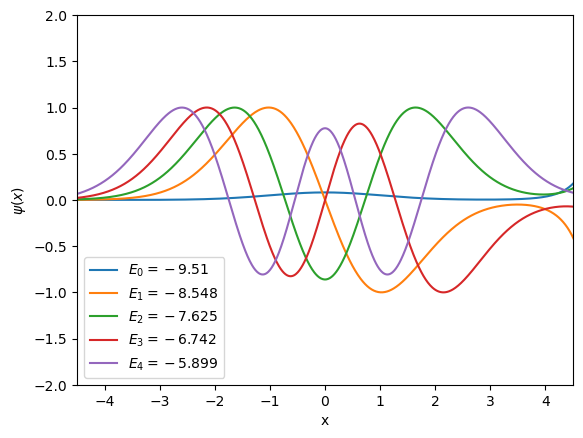

In [90]:
psis2=np.zeros(len(Es2))

for i in range(len(psis2)):
    psi_2=Numerov(xs2,V2,Es2[i])/np.max(Numerov(xs2,V2,Es2[i]))
    plt.plot(xs2,psi_2, label="$E_{%s}=%s$"%(i,Es2[i]))
    plt.legend()

plt.xlabel("x")
plt.ylabel("$\psi(x)$")
plt.xlim(-4.5,4.5)
plt.ylim(-2,2)

                                    
                         

### j)

In [91]:
def V3(x):
    return -4/(1+x**2)**2

In [99]:
Es3=[]
E=-3
dE=0.01
while len(Es3)<2:
    psi1=Numerov(xs,V3,E)[-1]
    psi2=Numerov(xs,V3,E+dE)[-1]
    if psi1*psi2<0:
        Es3.append(round(E,3))
    E=E+dE

Es3

[-2.48, -0.43]

In [96]:
#Es3=np.array([-1.478,-0.163])

Text(0, 0.5, '$\\psi(x)$')

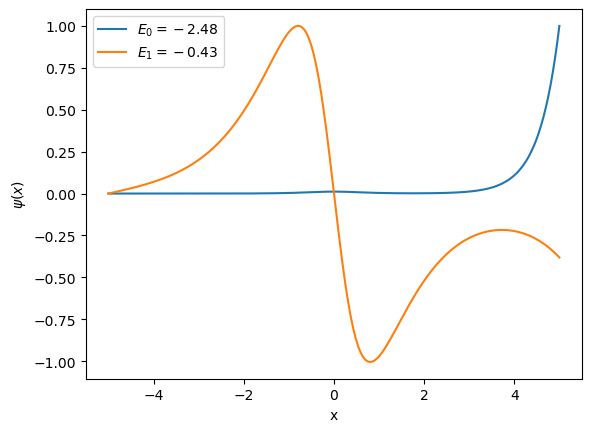

In [100]:
psis3=np.zeros(len(Es3))

for i in range(len(psis3)):
    psi_3=Numerov(xs2,V3,Es3[i])/np.max(Numerov(xs2,V3,Es3[i]))
    plt.plot(xs2,psi_3, label="$E_{%s}=%s$"%(i,Es3[i]))
    plt.legend()

plt.xlabel("x")
plt.ylabel("$\psi(x)$")